In [4]:
import numpy as np
import random
import json
import pygad
import time
random.seed(42)
import matplotlib.pyplot as plt
from collections import defaultdict
import os
datasets = ["easy_dataset_1.json", "easy_dataset_2.json",
                          "medium_dataset_1.json", "medium_dataset_2.json",
                          "hard_dataset_1.json", "hard_dataset_2.json", "hard_dataset_3.json" , "hard_dataset_4.json"]

In [5]:
def inspect_solution(solution, context, verbose=True):
    """
    Inspects the solution to identify constraint violations.
    
    Parameters:
        context (dict): A dictionary containing 'preferences', 'authorship', 'friendship', and 'capacity'.
        solution (list of list): A binary matrix where solution[i][j] = 1 if reviewer i reviews paper j.
        
    Output:
        Prints violations for each constraint if verbose=True.
        return the number of violations of soft constraints
        assert that there are no violations of hard constraints
    """

    #check authorship contraint
    authorship_violations = int(np.sum(np.multiply(solution, context["authorship"])))
    assert(authorship_violations == 0)
    if verbose:
        print(f"Authorship constraint violations: {authorship_violations}")

    #check friendship constraint
    friendship_violations = 0
    friendship = np.triu(context["friendships"])
    agents1, agents2 = np.where(friendship == 1)
    for i1, i2 in zip(agents1, agents2):
        for j in range(context["num_papers"]):
            if solution[i1][j] and solution[i2][j]:
                friendship_violations += 1

    if verbose:
        print(f"Friendship constraint violations: {friendship_violations}")


    #check capacity constraint for paper
    capacity_violations_paper = 0
    capacity_interval = (context["min_reviews_per_paper"], context["max_reviews_per_paper"])
    reviews_per_paper = np.sum(solution, axis=0)
    for i in reviews_per_paper:
        if i < capacity_interval[0] or i > capacity_interval[1]:
            capacity_violations_paper += 1
    assert(capacity_violations_paper == 0)
    if verbose: 
        print(f"Capacity constraint violations for papers: {capacity_violations_paper}")

    #check capacity constraint for reviewer
    capacity_violations_reviewer = 0
    max_reviews_per_reviewer = context["reviewer_capacity"]
    reviews_per_reviewer = np.sum(solution, axis=1)
    for i in reviews_per_reviewer:
        if i < max_reviews_per_reviewer:
            capacity_violations_reviewer += 1
    if verbose:
        print(f"Capacity constraint violations for reviewers: {capacity_violations_reviewer}")

    #return the number of violations of soft constraints
    return friendship_violations + capacity_violations_reviewer

# Task 1 - Representation

---
## Data format

The first step in the design of the genetic algorithm is translating datas from the context to concrete data types we can manipulate within the algorithm. The next section shows the choices we made concerning the  `Preference Matrix` $P$,  `Authorship Matrix` $A_{\text{auth}}$ and `Friendship Matrix` $F$.


In the following, 
   - $ n $ is the number of reviewers.
   - $ m $ is the number of papers.

 `Preference Matrix` $P$
   - **Purpose**: This matrix captures the satisfaction each reviewer has for each paper.
   - **Data type**: np.array((n, m))
   - **Description**: Each element $ P[i, j] $ represents how much reviewer $ i $ prefers reviewing paper $ j $. 

$$
P \in \mathbb{N}^{n \times m}, \quad P[i, j] \text{ is the preference of reviewer } i \text{ for paper } j
$$


 `Authorship Matrix` $A_{\text{auth}}$
   - **Purpose**: This matrix indicates which reviewer is the author of which paper.
   - **Data type**: np.array((n, m))
   - **Description**: Each element $ A_{\text{auth}}[i, j] $ is $ 1 $ if reviewer $ i $ is the author of paper $ j $, and $ 0 $ if he is not. This is important because we want to avoid authors reviewing their own papers.
$$
A_{\text{auth}} \in \{0, 1\}^{n \times m}, \quad A_{\text{auth}}[i, j] = 1 \text{ if reviewer } i \text{ authored paper } j
$$


 `Friendship Matrix` $ F $
   - **Purpose**: This matrix represents the friendship relationships between reviewers. Friendships are important because two friends should not review the same paper to avoid conflicts of interest.
   - **Data type**: np.array((n, n))
   - **Description**: Each element $ F[i, j] = 1 $ if reviewers $ i $ and $ j $ are friends, and $ 0 $ if they are not.

$$
F \in \{0, 1\}^{n \times n}, \quad F[i, j] = 1 \text{ if reviewer } i \text{ and reviewer } j \text{ are friends}
$$

---
## Fitness function

The fitness function is the kernel of every genetic algorithm. It enables rating the agents according to several criterion extracted from the context.

In order to make the solution feat best with the context we decided to split the constraints into two categories :
- `Rigid constraints`: Those are the constraints that should be respected by every generated agent. They are not part of the fitness considering they are required for an agent to exist. It concerns the number of reviewers per paper and the authorship criteria.
- `Flexible constraints`: Those are the constraints that an agent would prefer to respect, but are not required for him to exist. They are part of the fitness function. It concerns the number of paper per reviewer and the friendship criteria.


Thus, the fitness function we use works like so:
1. `Get reviewers satisfaction`: Multiply the agent by the preference matrix $P$ to obtain the **Satisfaction Matrix $S$**. This matrix contains the satisfaction each reviewer gets from each paper he reviews.

$$ S = Agent \; · \; P \quad \text{(element wise product)}$$

2. `Check friendship constraint`: Each pair of reviewers that review the same paper have the satisfaction they get by reviewing the "shared" paper divided by 2. This operation is cumulative over the different pairs of friends. Thus, if $R_1, R_2$ and $R_3$ review the same paper, their satisfaction for this paper will be divided by 4.

$$ S[i,j] = S[i, j]/2 \qquad  \forall i' \:     \text{such that} \: F[i,i'] == 1 \: \text{and} \: S[i',j] $$

3. `Check paper per reviewer contraint`: Reviewers that review more than **max_papers** papers divide all their satisfactions proportionnally to the number of excess papers.

$$ S[i] = S[i]/excess \quad \text{with} \; excess = (sum(S[i]) - max papers) \quad \text{if} \; sum(S[i]) > max papers $$

4. `Sum and normalization` : Compress the $S$ matrix into a final score which belongs to $[0;100]$ by summing all its coefficients.

# Task 2 - Crossover and Mutation

---
## Crossover and first population

Now we have our fitness defined, we need to handle the mating between the agents. To do so, we have to implement a crossover function that combines two parents into one unique child. In order to always respect the rigid constraints (as previously announced), we built the crossover functions in a way to preserve the characteristics of the parents. Thus, two parents who respect the rigid contraints (we refer that as valid agents) can only generate a child who also respects those constraints.

To make sure no invalid agents are part of the solution, we manually generate the first generation of agents in a way they also respect those constraints.

With both adjustement, we make sure only valid agents are part of the population, and so at every step of the algorithm. 

---
## Mutation

Mutations are used to introduce randomness into the agent generation, independently of its parents' characteristics. The challenge, as for the crossovers, is to design a function that preserves the integrity of the rigid constraints.

To mutate a solution, we randomly select a paper and, with equal probability, we either:

- `Add` a reviewer, if it is possible to do so without violating the `rigid constraints`.
- `Remove` a reviewer, if it is possible to do so without violating the `rigid constraints`.
- `Swap` a reviewer currently assigned to the paper with one that is not, without violating the `rigid constraints`.


Since the first two options are often not feasible due to potential constraint violations, if they are not possible, we perform a swap. If a swap is not possible, we do nothing.

In [6]:
class GeneticAlgorithm:
    def __init__(self, file_path:str):
        self.context = self.import_data(file_path)
        self.cross_over = self.half_splitted_crossover
    

    def import_data(self, file:str): # json file 
        with open(file) as f:
            data = json.load(f)

            # convert to numpy array
            data["preferences"] = np.array(data["preferences"])
            data["authorship"] = np.array(data["authorship"])
            data["friendships"] = np.array(data["friendships"])

        return data


######################## FITNESS FUNCTIONS ########################
    def fitness(self, agent: np.array):
        """ 
        Returns a score corresponding to the satisfaction the agent obtains with respect to the flexible 
        constraints we want him to respect.
        """
        agent = agent.reshape(self.context["preferences"].shape)
        n = self.context["num_reviewers"]
        m = self.context["num_papers"]

        max_papers = self.context["reviewer_capacity"]

        #satisfaction matrix
        satisfaction = (agent * self.context["preferences"]).astype("float64")
        
        #check friendship constraint
        friendship = np.triu(self.context["friendships"])
        friends_indices = np.where(friendship == 1)
        friends = [(friends_indices[0][i], friends_indices[1][i]) for i in range(len(friends_indices[0]))]
        
        #iterate over every pair of friends
        for (i1, i2) in friends:
            # And then over all the papers they could review
            for j in range(m):
                if satisfaction[i1, j] and satisfaction[i2, j]: # Case where 2 friends review the same paper
                    satisfaction[i1, j] = satisfaction[i1, j]/2
                    satisfaction[i2, j] = satisfaction[i2, j]/2
    

        #check capacity constraint for reviewer
        for i in range(n):
            reviewer = satisfaction[i]
            nb_papers_reviewed = len(np.where(reviewer != 0)[0])

            if max_papers < nb_papers_reviewed:
                satisfaction[i] = satisfaction[i] / (1 + (nb_papers_reviewed - max_papers))


        #normalize
        satisfaction = np.sum(satisfaction) / np.sum(self.context["preferences"]) * 100

        return satisfaction
    
    
    def fitness_wrapper(self, ga_instance, solution, solution_idx):
        return self.fitness(solution) #make sure to pass the context and to have define fitness before
    

######################## CROSSOVER FUNCTIONS ########################
    def half_splitted_crossover(self, parents, offspring_size, ga_instance):
        """
        Build new agents by cutting each parent in half (vertically) and sticking them together. 

        Parameters:
            parents (np.array) : Array of parents we want to mate.
            offspring_size (tuple) : Number of offsprings we want to generate and their respective length.
            ga_instance (pygad.GA) : Reference to the genetic algorithm we are executing. Can be used to 
            access the experience parameters.

        Return:
            new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        new_agents = np.empty(offspring_size)
        preferences = self.context["preferences"]
        width = np.shape(preferences)[1]

        for k in range(offspring_size[0]):
            #choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            #reshape them into array dimensions according to the preference matrix
            daddy = parents[i].reshape(np.shape(preferences))
            mommy = parents[j].reshape(np.shape(preferences))

            #build the child by pasting the left part of daddy and the right part of mommy together
            child = np.zeros_like(preferences)
            child[:, :width//2] = daddy[:, :width//2]
            child[:, width//2:] = mommy[:, width//2:]

            assert len(child.flatten() == offspring_size[1])

            #flatten the child to make its dimension feat with the expected one
            new_agents[k] = child.flatten()

        return new_agents


    def rdm_col_crossover(self, parents, offspring_size, ga_instance):
        """
        Build new agents by randomly picking columns among one of each of its parents. 

        Parameters:
            parents (np.array) : Array of parents we want to mate.
            offspring_size (tuple) : Number of offsprings we want to generate and their respective length.
            ga_instance (pygad.GA) : Reference to the genetic algorithm we are executing. Can be used to 
            access the experience parameters.

        Return:
            new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        real_dim = np.shape(self.context["preferences"])
        new_agents = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            #choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            #get genitors and create futur child
            genitors = (parents[i].reshape(real_dim), parents[j].reshape(real_dim))
            child = np.zeros(real_dim)

            #choose the columns randomly and fill the child with
            for l in range(real_dim[1]):
                child[:, l:l+1] = genitors[random.randint(0,1)][:, l:l+1]

            assert len(child.flatten() == offspring_size[1])
            new_agents[k] = child.flatten()

        return new_agents

    def and_crossover(self, parents, offspring_size, ga_instance):
        """
        Apply the AND operator between the parents columns to build the child ones.
        Fill the column with 1 if needed, in order to keep respecting the constraints.

        Parameters:
            parents (np.array) : Array of parents we want to mate.
            offspring_size (tuple) : Number of offsprings we want to generate and their respective length.
            ga_instance (pygad.GA) : Reference to the genetic algorithm we are executing. Can be used to 
            access the experience parameters.

        Return:
            new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        real_dim = np.shape(self.context["preferences"])
        new_agents = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            #choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            #get genitors and create futur child
            daddy = parents[i].reshape(real_dim).astype("int")
            mommy = parents[j].reshape(real_dim).astype("int")
            child = np.zeros(real_dim)

            #AND operator between every couple of columns 
            for l in range(real_dim[1]):
                merged_col = daddy[:, l:l+1] & mommy[:, l:l+1]
                authors = self.context["authorship"][:, l:l+1]

                #insure the min reviewers per paper and authorship are respected
                while np.sum(merged_col) < self.context["min_reviews_per_paper"]:
                    available_cells = (merged_col == 0) & (authors == 0)
                    available_indices = [i for i in range(np.shape(merged_col)[0]) if available_cells[i]]
                    
                    #case where the constraints are incompatible
                    if len(available_indices) == 0:
                        print(f"There are too many authors and not enough reviewers for paper {l}.")
                        assert(0)
                    
                    merged_col[random.choice(available_indices)][0] = 1
            
                child[:, l:l+1] = merged_col

            assert len(child.flatten() == offspring_size[1])
            new_agents[k] = child.flatten()

        return new_agents.astype("int")


    def or_crossover(self, parents, offspring_size, ga_instance):
        """
        Apply the OR operator between the parents columns.
        Fill the column with 0 if needed, in order to keep respecting the constraints.

        Parameters:
            parents (np.array) : Array of parents we want to mate.
            offspring_size (tuple) : Number of offsprings we want to generate and their respective length.
            ga_instance (pygad.GA) : Reference to the genetic algorithm we are executing. Can be used to 
            access the experience parameters.

        Return:
            new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        real_dim = np.shape(self.context["preferences"])
        new_agents = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            #choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            #get genitors and create futur child
            daddy = parents[i].reshape(real_dim).astype("int")
            mommy = parents[j].reshape(real_dim).astype("int")
            child = np.zeros(real_dim)

            #OR operator between every couple of columns 
            for l in range(real_dim[1]):
                merged_col = daddy[:, l:l+1] | mommy[:, l:l+1]

                #insure the max reviewers per paper and authorship are respected
                while self.context["max_reviews_per_paper"] < np.sum(merged_col):
                    available_cells = (merged_col == 1)
                    available_indices = [i for i in range(np.shape(merged_col)[0]) if available_cells[i]]
                    
                    merged_col[random.choice(available_indices)][0] = 0
            
                child[:, l:l+1] = merged_col

            assert len(child.flatten() == offspring_size[1])
            new_agents[k] = child.flatten()

        return new_agents.astype("int")


######################## MUTATION FUNCTIONS ########################
    #----Custom mutation/crossover functions----

    def mutation(self, offspring, ga_instance): 
        """
        Swap a paper from a reviewer to another making sure that the
        constraints are respected or add or remove a paper from a reviewer.
        """
        
        #choose a random solution
        r = random.randint(0, offspring.shape[0]-1)
        solution = offspring[r]
        solution = solution.reshape(self.context["preferences"].shape)
        n, m = self.context["preferences"].shape

        #choose a random paper
        paper = random.randint(0, m-1)
        #choose randomly between adding removing or swapping a paper

        mutation_flag = False
        option = random.choice(["add", "remove", "swap"])

        if option == "add":
            if np.sum(solution[:, paper]) < self.context["max_reviews_per_paper"]:
                #list of free reviewers that can review the paper
                free_reviewers = np.where(solution[:, paper] == 0)[0]
                #check authorship constraint
                free_reviewers = [r for r in free_reviewers if self.context["authorship"][r, paper] == 0]

                if len(free_reviewers) > 0:
                    #choose a random reviewer
                    reviewer = random.choice(free_reviewers)
                    solution[reviewer, paper] = 1
                    mutation_flag = True
        
        if option == "remove":
            if np.sum(solution[:, paper]) > self.context["min_reviews_per_paper"]:
                #list of reviewers that we can remove the paper
                reviewers = np.where(solution[:, paper] == 1)[0]
                if len(reviewers) > 0:
                    #choose a random reviewer
                    reviewer = random.choice(reviewers)
                    solution[reviewer, paper] = 0
                    mutation_flag = True


        if option == "swap" or not mutation_flag: 
            #choose 1 reviewer that is reviewing the paper
            reviewers = np.where(solution[:, paper] == 1)[0]
            free_reviewers = np.where(solution[:, paper] == 0)[0]
            #check authorship constraint
            free_reviewers = [r for r in free_reviewers if self.context["authorship"][r, paper] == 0]
            
            if len(reviewers) > 0 and len(free_reviewers) > 0:
                reviewer1 = random.choice(reviewers)
                reviewer2 = random.choice(free_reviewers)
                solution[reviewer1, paper] = 0
                solution[reviewer2, paper] = 1
                mutation_flag = True

        offspring[r] = solution.flatten()
        return offspring


######################## RUNNING FUNCTIONS ########################
    def run(self, num_generations=500, num_parents_mating=5, sol_per_pop=30,
            parent_selection_type="rws", mutation_percent_genes=10):
        
        pop = self.generate_initial_population(sol_per_pop, self.context["num_papers"]*self.context["num_reviewers"])
        #print(pop)
        self.ga_instance =  pygad.GA(num_generations=num_generations,
                                        initial_population=pop,
                                        num_parents_mating=num_parents_mating, 
                                        fitness_func=self.fitness_wrapper,
                                        sol_per_pop=sol_per_pop,
                                        num_genes=self.context["num_papers"]*self.context["num_reviewers"],
                                        gene_space=[0,1],
                                        parent_selection_type=parent_selection_type,
                                        mutation_percent_genes= mutation_percent_genes,
                                        mutation_type=self.mutation,
                                        crossover_type=self.cross_over,
                                        )
        self.ga_instance.run()
        solution, solution_fitness, _ = self.ga_instance.best_solution()

        return solution.reshape(self.context["preferences"].shape), solution_fitness
        

    # Fonction pour générer un individu valide
    def generate_valid_individual(self):
        """ 
        Generate a valid individual that respects the constraints of the problem.

        Returns:
            individual (np.array): A binary matrix where individual[i][j] = 1 if reviewer i reviews paper j.
        """
        individual = np.zeros_like(self.context["preferences"])
        _, m = np.shape(self.context["preferences"])

        for paper in range(m): 
            possible_reviewers = np.where(self.context["authorship"][:, paper] == 0)[0]
            assert len(possible_reviewers) >= self.context["min_reviews_per_paper"], "Not enough reviewers to review the paper"
            num_reviewers = random.randint(self.context["min_reviews_per_paper"], min(self.context["max_reviews_per_paper"], len(possible_reviewers)))
            
            reviewers = random.sample(list(possible_reviewers), num_reviewers)
            for reviewer in reviewers:
                individual[reviewer, paper] = 1
        
        return individual.flatten()

            

    # Fonction pour générer une population valide
    def generate_initial_population(self, pop_size, gene_length):
        """
        Generate a population of valid individuals that respect the constraints of the problem.

        Parameters:
            pop_size (int): The number of individuals in the population.
            gene_length (int): The length of the gene of each individual.

        Returns:
            population (np.array): A 2D array where each row is an individual of the population.
        """
        population = np.array([self.generate_valid_individual() for _ in range(pop_size)])
        return population


# Task 3 - Complexity and diversity

---
## Multiple crossovers

To explore possiblities and identify an effective algorithm, we experimented different crossover methods. Each crossover function we designed implements a unique mating strategy, retaining and combining different amount/type of information from the parents. As mentioned earlier, we ensure the generated solutions always respect the rigid constraints. 

Below are the details of our various crossover implementations:

- `Crossover using half of each parent` : Create a child by assembling the left part of one parent with the right part of the other. It automatically insures the number of reviewers per paper and authorship constraints are conserved from parents to the child.

- `Random column crossover` : Create a child by randomly picking a column belonging to one parent as the new child column. The selected parent columns always have the same index as the child ones. This method has the same natural properties as the previous one.

- `AND operating crossover` : Child columns come from both corresponding parents columns merged using $AND$ binary operator. We sometimes need to manually complete the column to reach the minimum of reviewers per paper.

- `OR operating crossover` : Child columns come from both corresponding parents columns merged using $OR$ binary operator. We sometimes need to manually remove some reviewers to go below the maximum of reviewers per paper.

---
## Tuning of Genetic Algorithm parameters

Given the numerous parameters in our Genetic Algorithm, we aim to explore them in order to determine the most optimal ones. The following code focuses on varying each parameter individually while keeping the others fixed. 

### Parameters to Tune

We will vary the following parameters:

1. **`num_generations`**: The number of generations to run the GA.
2. **`num_parents_mating`**: The number of parents that will mate to produce offspring.
3. **`sol_per_pop`**: The number of solutions per population.
4. **`parent_selection_type`**: The type of parent selection method (e.g., tournament, random, roulette wheel).
5. **`mutation_percent_genes`**: The percentage of genes that will undergo mutation in each generation.
6. **`crossover_type`**: The type of crossover method to apply.

### Parameter Ranges

We will vary the parameters across the following values:

- **`num_generations`**: [50, 100, 500, 1000, 5000, 10000]
- **`num_parents_mating`**: [5, 10, 20, 30]
- **`sol_per_pop`**: [30, 40, 50, 100, 200, 300]
- **`parent_selection_type`**: ["tournament", "random", "rws", "sss", "rank", "sus"]
- **`mutation_percent_genes`**: [5, 10, 15, 20, 25, 30]
- **`crossover_type`**: ["crossover1", "crossover2", "crossover3", "crossover4"]

### Fixed parameters

While one parameter is varied, all others are kept fixed at the following values:

- `num_generations = 500`
- `num_parents_mating = 5`
- `sol_per_pop = 30`
- `parent_selection_type = "rws"`
- `mutation_percent_genes = 10`
- `cross_over = crossover1`

### Evaluation Process

For each configuration, we compute the associated fitness score. To ensure robustness, we repeat this process across multiple datasets and calculate the average score.

### Output

The result is a dictionary of dictionaries, where each key corresponds to a parameter and its associated values across different datasets.

In [7]:
#Utils
def parameter_tuning(ga):
    """
    We will run the genetic algorithm with different parameters and return the best one,
    we repeat that across different datasets and then average the results to obtain more robust results .

    Parameters:
        ga (GeneticAlgorithm): An instance of the GeneticAlgorithm class.

    Returns:
        averages (dict): A dictionary containing the fitness for each value of each parameters.
    """
    dicts = []
    for d in datasets:
        ga.context = ga.import_data(f"datasets/{d}")
        param_ranges = {
        "num_generations": [50, 100, 500, 1000, 5000, 10000],
        "num_parents_mating": [5, 10, 20, 30 ],
        "sol_per_pop": [30, 40, 50, 100, 200, 300],
        "parent_selection_type": ["tournament", "random", "rws", "sss", "rank", "sus"],
        "mutation_percent_genes": [5, 10, 15, 20, 25, 30],
        "crossover_type": ["crossover1", "crossover2", "crossover3", "crossover4"] }

        
        param_scores = dict() # should be exactly the same shape as param_ranges (it is the output)t
        # varying num generations
        for num_generations in param_ranges["num_generations"]:
            _, score = ga.run(num_generations=num_generations)

            if "num_generations" not in param_scores:
                param_scores["num_generations"] = {num_generations: score}
            else:
                param_scores["num_generations"][num_generations] = score
        print("Done with num_generations")

        # varying num parents mating
        for num_parents_mating in param_ranges["num_parents_mating"]:
            _, score = ga.run(num_parents_mating=num_parents_mating)
            if "num_parents_mating" not in param_scores:
                param_scores["num_parents_mating"] = {num_parents_mating: score}
            else:
                param_scores["num_parents_mating"][num_parents_mating] = score
        print("Done with num_parents_mating")


        # varying sol per pop
        for sol_per_pop in param_ranges["sol_per_pop"]:
            _, score = ga.run(sol_per_pop=sol_per_pop)
            if "sol_per_pop" not in param_scores:
                param_scores["sol_per_pop"] = {sol_per_pop: score}
            else:
                param_scores["sol_per_pop"][sol_per_pop] = score
        print("Done with sol_per_pop")
        
        # varying parent selection type
        for parent_selection_type in param_ranges["parent_selection_type"]:
            _, score = ga.run(parent_selection_type=parent_selection_type)

            if "parent_selection_type" not in param_scores:
                param_scores["parent_selection_type"] = {parent_selection_type: score}
            else:
                param_scores["parent_selection_type"][parent_selection_type] = score
        print("Done with parent_selection_type")
        

        # varying mutation percent genes
        for mutation_percent_genes in param_ranges["mutation_percent_genes"]:
            _, score = ga.run(mutation_percent_genes=mutation_percent_genes)
            if "mutation_percent_genes" not in param_scores:
                param_scores["mutation_percent_genes"] = {mutation_percent_genes: score}
            else:
                param_scores["mutation_percent_genes"][mutation_percent_genes] = score
        print("Done with mutation_percent_genes")

        # varying crossover type
        for crossover_type in param_ranges["crossover_type"]:
            if crossover_type == "crossover1":
                ga.cross_over = ga.half_splitted_crossover
            elif crossover_type == "crossover2":
                ga.cross_over = ga.rdm_col_crossover
            elif crossover_type == "crossover3":
                ga.cross_over = ga.and_crossover
            else:
                ga.cross_over = ga.or_crossover
            
            _, score = ga.run()
            if "crossover_type" not in param_scores:
                param_scores["crossover_type"] = {crossover_type: score}
            else:
                param_scores["crossover_type"][crossover_type] = score
        print("Done with crossover_type")

        dicts.append(param_scores)



   # average the scores of each dict
    accumulator = defaultdict(lambda: defaultdict(float)) 
    count = defaultdict(lambda: defaultdict(int)) 
    
    for d in dicts:
        for key, sub_dict in d.items():  
            for sub_key, value in sub_dict.items():  
                accumulator[key][sub_key] += value  
                count[key][sub_key] += 1  #

    averages = {
        key: {sub_key: accumulator[key][sub_key] / count[key][sub_key]  
            for sub_key in sub_dict}
        for key, sub_dict in accumulator.items()
    }

    return averages

In [20]:
# Use the stored results instead of recomputing the code
def saving_scores(scores_according_to_hyperparameters):
    with open("scores_according_to_hyperparameters.json", "w") as json_file:
        json.dump(scores_according_to_hyperparameters, json_file, indent=4)

def reading_scores():
    with open("scores_according_to_hyperparameters.json") as json_file:
        return json.load(json_file)

recalculate = True # set to True if you want to recalculate the scores (but it takes a lot of time)
if recalculate or not os.path.exists("scores_according_to_hyperparameters.json"):
    modele = GeneticAlgorithm("datasets/easy_dataset_1.json")
    scores_according_to_hyperparameters = parameter_tuning(modele)
    saving_scores(scores_according_to_hyperparameters)
else:
    scores_according_to_hyperparameters = reading_scores()

/home/alexis-le-s/miniconda3/envs/venv/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_type
Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_type
Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_type
Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_type
Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_type
Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_typ

# Task 4 - Evaluation

In the following section, we visualize how the fitness changes with respect to each parameter by varying the values of these parameters.

### Number of generations analysis

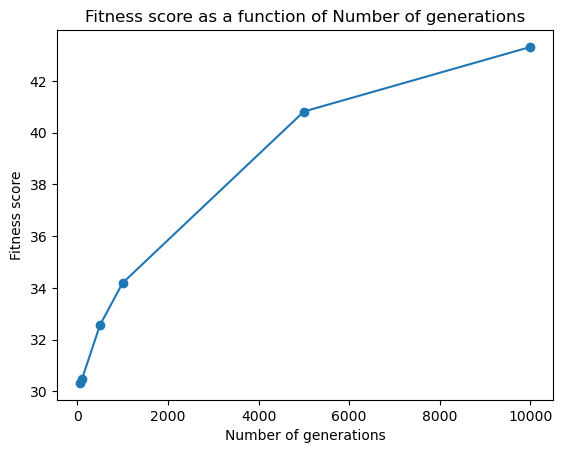

In [21]:
# plot the results
def plot_scores_as_curve(scores_according_to_hyperparameters, key:str, xlabel:str):
    score = scores_according_to_hyperparameters[key]
    x = list(score.keys())
    y = list(score.values())
    assert len(x) == len(y)
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel("Fitness score")
    plt.title(f"Fitness score as a function of {xlabel}")
    plt.show()

plot_scores_as_curve(scores_according_to_hyperparameters, "num_generations", "Number of generations")


### Number of parents mating analysis

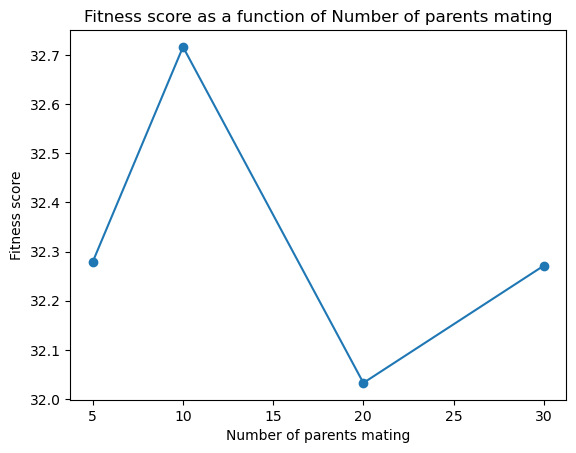

In [22]:
plot_scores_as_curve(scores_according_to_hyperparameters, "num_parents_mating", "Number of parents mating")

### Size of the population per generation

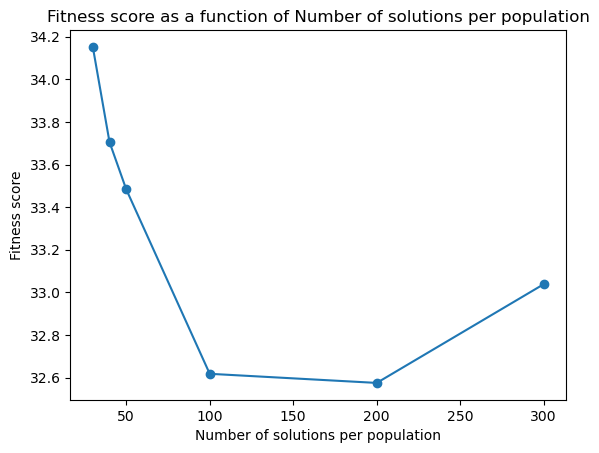

In [23]:
plot_scores_as_curve(scores_according_to_hyperparameters, "sol_per_pop", "Number of solutions per population")

### Mutation rate

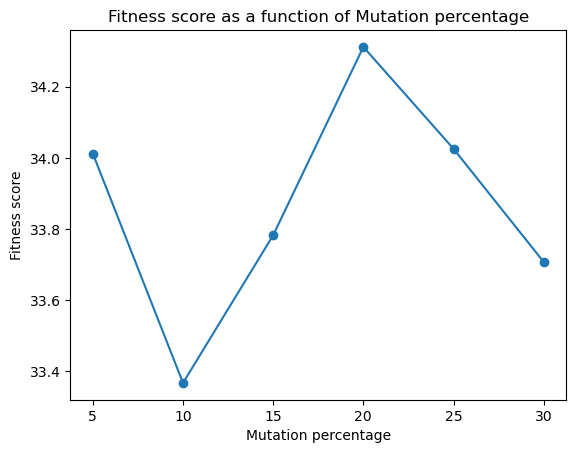

In [24]:
plot_scores_as_curve(scores_according_to_hyperparameters, "mutation_percent_genes", "Mutation percentage")

### Parent selection method

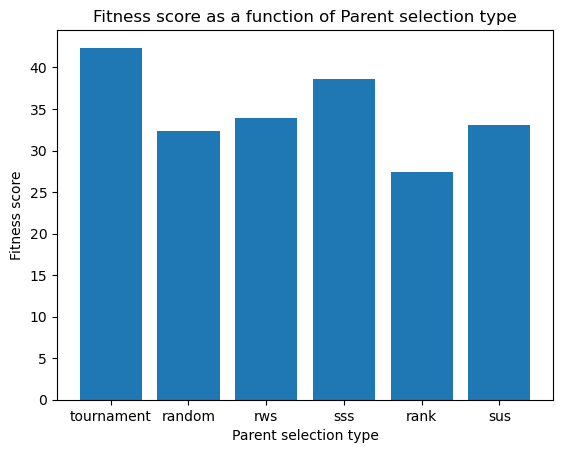

In [25]:
def plot_scores_as_bar(scores_according_to_hyperparameters, key:str, xlabel:str):
    score = scores_according_to_hyperparameters[key]
    x = list(score.keys())
    y = list(score.values())
    assert len(x) == len(y)
    plt.bar(x, y)
    plt.xlabel(xlabel)
    plt.ylabel("Fitness score")
    plt.title(f"Fitness score as a function of {xlabel}")
    plt.show()

plot_scores_as_bar(scores_according_to_hyperparameters, "parent_selection_type", "Parent selection type")

### Crossover method 

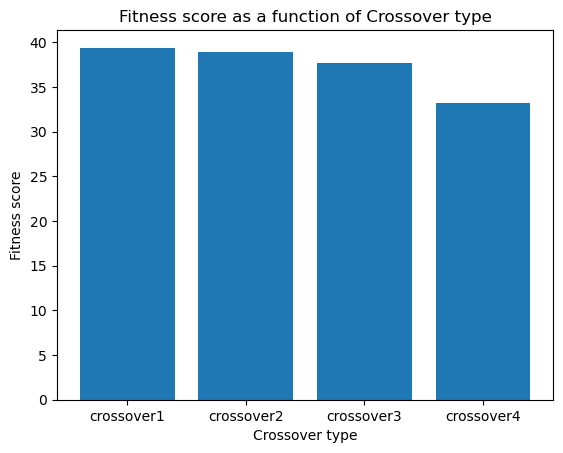

In [26]:
plot_scores_as_bar(scores_according_to_hyperparameters, "crossover_type", "Crossover type")

### Best Parameters for Final Computation

In [27]:
# find the best hyperparameters
def find_best_hyperparameters(scores_according_to_hyperparameters):
    best = {}
    for key, value in scores_according_to_hyperparameters.items():
        best[key] = max(value, key=value.get)
    return best

best_parameters = find_best_hyperparameters(scores_according_to_hyperparameters)
best_parameters

{'num_generations': 10000,
 'num_parents_mating': 10,
 'sol_per_pop': 30,
 'parent_selection_type': 'tournament',
 'mutation_percent_genes': 20,
 'crossover_type': 'crossover1'}


After conducting our study, the optimal parameters identified are as follows:

- **Number of Generations**: `10000`
- **Number of Parents Mating**: `10`
- **Solutions per Population**: `30`
- **Parent Selection Type**: `Tournament`
- **Mutation Percentage per Gene**: `20%`
- **Crossover Type**: `Crossover1`

These parameters will be used to compute the final solution for each problem.

Note that those parameters can depend on the specific generation we take into account. However, experiments show non significant difference between their values over several trials. 

# Results and execution time for each problem (datatets)

In this part, we provide answers to each problem (corresponding to different datasets). We report the solutions found using the Genetic Algorithm in a JSON format (in the file `answers.json`), including the associated fitness, execution runtime, and problem size.

In [30]:
"""
The following code will run the genetic algorithm on all datasets with the best parameters (the ones we found in the previous section) 
and save the results and execution time in a json file.
"""

answer_dict = dict() # key : dataset (str), value : execution time
model = GeneticAlgorithm("datasets/easy_dataset_1.json")
for dataset in datasets:
    temp_dict = dict()
    model.context = model.import_data(f"datasets/{dataset}")
    start_time = time.perf_counter()
    model.cross_over = model.half_splitted_crossover # finded in our hyperparameter tuning stydy
    solution, fitness = model.run(
        num_generations=1000,
        num_parents_mating=10,
        sol_per_pop=30,
        parent_selection_type="tournament",
        mutation_percent_genes=20
    )
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    temp_dict["solution"] = solution.tolist()
    temp_dict["fitness"] = fitness
    temp_dict["execution_time"] = execution_time
    answer_dict[dataset] = temp_dict

    complexity = model.context["num_reviewers"] * model.context["num_papers"]
    answer_dict[dataset]["problem size"] = complexity

    inspect_solution(solution, model.context, verbose=False) # if there was a violation of a hard constraint, an assertion error would be raised


if 1 : # put 1 to save the results in json 
    with open("answers.json", "w") as json_file:
        json.dump(answer_dict, json_file, indent=4) 
    


### Execution time for each dataset

We have measured the runtime of our GA for each dataset. If we define the problem size as $ problem size = \text{num\_paper} \times \text{num\_reviewer} $, we observe a linear relationship between the runtime and the problem size (as we can see on the graph below).

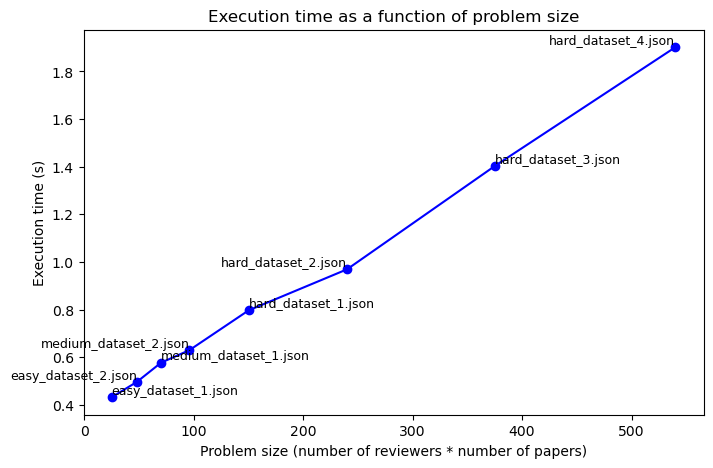

In [31]:
def plot_execution_time_as_a_function_of_problem_size(answer_dict):
    x = [answer_dict[dataset]["problem size"] for dataset in datasets]
    y = [answer_dict[dataset]["execution_time"] for dataset in datasets]

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o', linestyle='-', color='b')
    
    for i, dataset in enumerate(datasets):
        ha = 'left' if i % 2 == 0 else 'right'
        plt.text(x[i], y[i], dataset, fontsize=9, ha=ha, va='bottom')
    
    plt.xlabel("Problem size (number of reviewers * number of papers)")
    plt.ylabel("Execution time (s)")
    plt.title("Execution time as a function of problem size")
    plt.show()

plot_execution_time_as_a_function_of_problem_size(answer_dict)
